# Micro-Bob: automating microscopy tasks using LangChain and GPT 

Together with [Robert Haase](https://haesleinhuepf.github.io).  

Inspired by [bia-Bob](https://github.com/haesleinhuepf/bia-bob) and [napari-GPT](https://github.com/royerlab/napari-chatgpt).

microscope-gym demo microscope from  [Till Korten](https://github.com/thawn).

Prompt for executing microscope events using chatGPT and [LangChain](https://github.com/hwchase17/langchain). 

## Goals

1. **Simple demo:** Snap an image, move the stage, snap another image, display both images in Napari.
2. **Simple demo:** Take a stack, move the stage, take another stack, display both stacks in Napari.
3. **More complex demo:** (Looping). Scan the stage over a large FOV, snap an image at each position, find objects at each position, record positions, rank objects, take a stack of the top 3 objects.



## Requires microscope gym

For demo microscope.

`pip install git+https://gitlab.mn.tu-dresden.de/bia-pol/microscope-gym.git`

## Libraries and packages

In [1]:
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.tools import tool

from skimage.io import imread
# from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling

from microscope_gym.microscope_adapters.mock_scope import microscope_factory

import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imread

import stackview
import numpy as np
import napari

from bia_bob import bob

In [2]:
bob.__version__

'0.2.3'

## Setup

In [3]:
# global (notebook-wide) variables
image_storage = {}
viewers = []
tools = []

## Setting up a `mock_scope`

### Read the overview image that represents the entire sample

The mock_scope will later capture parts of this as the camera image

cl.OCLArray([[12812., 11554., 13445., ..., 11458., 12559., 13358.],
       [11395., 13524., 12875., ..., 11811., 11622., 12920.],
       [10955., 12812., 13898., ..., 12698., 11714., 12602.],
       ...,
       [13152., 12299., 11238., ..., 12728., 12176., 12362.],
       [12082., 12193., 12874., ..., 12933., 12406., 12971.],
       [11792., 15151., 13258., ..., 11692., 12196., 11708.]],
      dtype=float32)
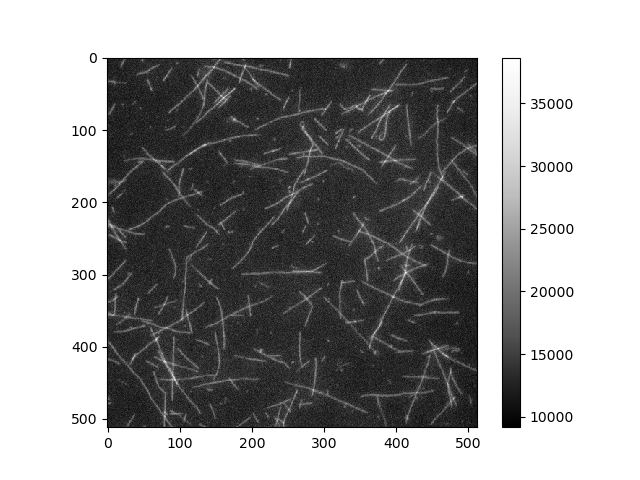
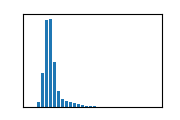

In [4]:
overview_image = imread("data/microtubules.tif")
overview_image[1]

### Initialize the microscope

In [5]:
scope = microscope_factory(overview_image=overview_image, camera_height_pixels=64, camera_width_pixels=64)
print('overview_image shape: ', scope.camera.overview_image.shape)
print('camera height: ', scope.camera.height_pixels)
print('camera width: ', scope.camera.width_pixels)
print('stage position: ', scope.get_stage_position())

overview_image shape:  (11, 512, 512)
camera height:  64
camera width:  64
stage position:  (5.0, 224.0, 224.0)


cl.OCLArray([[13333., 12674., 12710., ..., 17280., 19789., 23155.],
       [14852., 13533., 12958., ..., 16934., 23040., 23907.],
       [12320., 14136., 11454., ..., 16908., 18745., 24109.],
       ...,
       [13640., 13015., 13294., ..., 13465., 12201., 12963.],
       [13937., 13625., 13172., ..., 12354., 12336., 14124.],
       [14768., 12676., 12796., ..., 14052., 13848., 14378.]],
      dtype=float32)
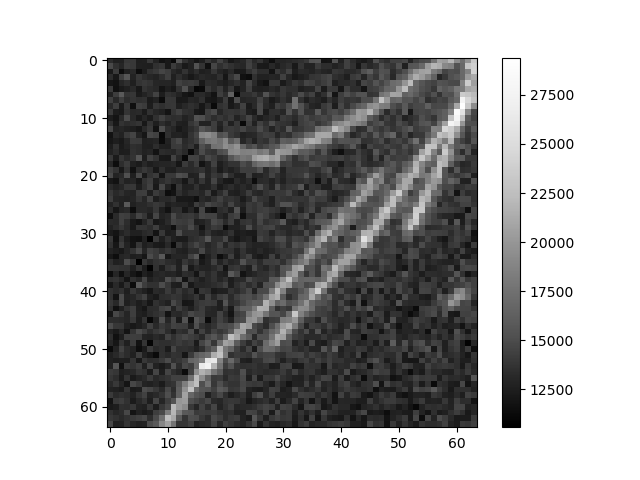
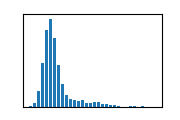

In [6]:
scope.acquire_image()

In [7]:
scope.get_stage_position()

(5.0, 224.0, 224.0)

In [8]:
scope.move_stage_by(relative_z_position_um=-1)
scope.get_stage_position()

(4.0, 224.0, 224.0)

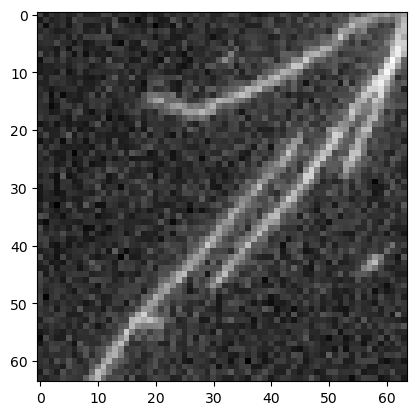

In [9]:
image=scope.acquire_image()
cle.imshow(image)

In [10]:
type(image)

pyclesperanto_prototype._tier0._pycl.OCLArray

In [11]:
scope.stage.z_range, scope.stage.y_range, scope.stage.x_range

((0.0, 11.0), (32.0, 480.0), (32.0, 480.0))

In [12]:
scope.get_field_of_view_um()

array([64., 64.])

## Tools

In [13]:
@tool
def show_image(image_name:str):
    """Useful for showing an image."""
    
    print("showing", image_name)
    
    image = image_storage[image_name]
    # display(stackview.insight(image))
    # image=scope.acquire_image()
    cle.imshow(image)
    
    return "The image " + image_name + " is shown above."

tools.append(show_image)

In [14]:
@tool
def show_z_stack(z_stack_image:str):
    """Useful for showing an image."""
    
    print("showing", z_stack_image)
    print("keys", image_storage.keys())
    
    z_stack = image_storage[z_stack_image]
    # display(stackview.insight(image))
    # image=scope.acquire_image()
    # cle.imshow(image)
    stackview.slice(z_stack)
    
    return "The z-stack " + z_stack + " is shown above."

tools.append(show_z_stack)

### Microscope tools

#### acquire_image

In [15]:
@tools.append
@tool
def acquire_image(image_name:str):
    '''

    Useful for acquiring an image on the microscope and storing it.
    
    '''
    # image_storage[image_name]=np.random.random((10,10))
    image_storage[image_name]=scope.acquire_image()
    print(f"Acquiring image ....{image_name}")
    image = image_storage[image_name]
    # cle.imshow(image)
    # return f"{image_name} was acquired."
    return f"the image was stored under the name {image_name}"
    # return

#### move stage

In [16]:
@tools.append
@tool
def move_stage_x(distance:str):
    '''

    Useful for moving a microscope stage in the x-axis.
    
    '''
    distance = float(distance)
    print(type(distance))
    z,y,x = scope.get_stage_position()
    new_x = x+distance
    scope.move_stage_to_nearest_position_in_range(z_position_um=z, y_position_um=y, x_position_um=new_x)
    new_position=scope.get_stage_position()
    return f"The stage was moved to {new_position}"
    # return

In [17]:
@tools.append
@tool
def move_stage_y(distance:str):
    '''

    Useful for moving a microscope stage in the y-axis.
    
    '''
    distance = float(distance)
    print(type(distance))
    z,y,x = scope.get_stage_position()
    new_y = y+distance
    scope.move_stage_to_nearest_position_in_range(z_position_um=z, y_position_um=new_y, x_position_um=x)
    new_position=scope.get_stage_position()
    return f"The stage was moved to {new_position}"
    # return

In [18]:
@tools.append
@tool
def move_stage_z(distance:str):
    '''

    Useful for moving a microscope stage in the z-axis.
    The stage moves a distance which is a value with units.  
    The numeral is the value and should be converted to a float.
    If I say 'Move 2 µm in the z direction', what are the units?
    If I say 'Move 2 µm in the z direction', what is the value?
    If I say 'Move 2 µm in the z direction', what is the direction?
    Don't use only 2 µm for stage movement in the z direction, use any value, but use only the value and not the units.
    Use the val without units in this tool.
    '''
    distance = float(distance)
    print(type(distance))
    z,y,x = scope.get_stage_position()
    new_z = z+distance
    scope.move_stage_to_nearest_position_in_range(z_position_um=new_z, y_position_um=y, x_position_um=x)
    new_position=scope.get_stage_position()
    return f"The stage was moved to {new_position}"
    # return

In [19]:
scope.acquire_z_stack?

Signature: scope.acquire_z_stack(z_range: tuple = ())
Docstring:
Acquire z-stack.

Args:
    z_range (start in µm, stop in µm, step in µm):
        range of z positions in µm, works like the range(start, stop, step) function argument:
        If step is not given, defaults to 1 µm.
        If stop and step are not given, start is interpreted as the stop argument and start will be the minimum stage z range.
        If the tuple is empty, the entire Stage.z_range is used.
File:      /opt/homebrew/Caskroom/mambaforge/base/envs/bob/lib/python3.11/site-packages/microscope_gym/interface/microscope.py
Type:      method

 here is the docstring for the microscope gym function that you may use for this tool:


    Signature: scope.acquire_z_stack(z_range: tuple = ())
    Docstring:
    Acquire z-stack.
    
    Args:
        z_range (start in µm, stop in µm, step in µm):
            range of z positions in µm, works like the range(start, stop, step) function argument:
            If step is not given, defaults to 1 µm.
            If stop and step are not given, start is interpreted as the stop argument and start will be the minimum stage z range.
            If the tuple is empty, the entire Stage.z_range is used.
    
    When you are done acquiring the stack, return the stack to the original XYZ position, the position before you applied this tool.
    

In [20]:
@tools.append
@tool
def extract_and_convert_to_float_tool(input_string: str) -> list:
    '''
    Extracts all numbers (both integers and floating point) from the provided string.
    
    Args:
    - input_string: The string from which to extract numbers.
    
    Returns:
    - A list of float representations of the numbers found in the string.
    '''
    import re
    
    # Extract numbers (including decimals) from the string
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", input_string)
    
    # Convert each number string to a float
    float_numbers = [float(num) for num in numbers]

    return float_numbers

# Usage (assuming you have set up the tool infrastructure):
# result = extract_and_convert_to_float_tool("Here are some numbers: 42, -15.5, 0.25, and 1001")


In [21]:
@tools.append
@tool
def acquire_z_stack(start_stop_step:str):
    '''

    Useful for taking a stack (set of slices) in the z-axis.
    The stage moves a distance which is a value with units.
    The input string contains a start z-position, and ending z-position, and the z-spacing (step) of the stack.
    You must parse these parameters extract each and convert them to three variables in python called "start", "stop", and "step".
    Make sure to remove the units and use only the numeric value, and make sure to convert the variables "start", "stop", and "step" to type float.
    Use these parameters for the code in this tool.

    here is the docstring for the microscope gym function that you may use for this tool:


    Signature: scope.acquire_z_stack(z_range: tuple = ())
    Docstring:
    Acquire z-stack.
    
    Args:
        z_range (start in µm, stop in µm, step in µm):
            range of z positions in µm, works like the range(start, stop, step) function argument:
            If step is not given, defaults to 1 µm.
            If stop and step are not given, start is interpreted as the stop argument and start will be the minimum stage z range.
            If the tuple is empty, the entire Stage.z_range is used.
    
    When you are done acquiring the stack, return the stack to the original XYZ position, the position before you applied this tool.
    
    '''
    import re
    
    print(f'{start_stop_step}')
    print(type(start_stop_step))
    # Extract numbers (including decimals) from the string
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", start_stop_step)

    # Convert each number string to a float
    float_numbers = [float(num) for num in numbers]

    start = float_numbers[0]
    stop = float_numbers[1]
    step = float_numbers[2]

    print(start)
    print(stop)
    print(step)
    # image_storage[stack_name]=scope.acquire_z_stack(start,stop,step)
    # image_storage[stack_name]=scope.acquire_z_stack(start,stop)
    # distance = float(distance)
    # print(type(distance))
    # z,y,x = scope.get_stage_position()
    z_stack_name = 'z-stack_image'
    image_storage[z_stack_name] = scope.acquire_z_stack((start, stop, step))
    # z_stack_image = image_storage
    # new_z = z+distance
    # scope.move_stage_to_nearest_position_in_range(z_position_um=new_z, y_position_um=y, x_position_um=x)
    # new_position=scope.get_stage_position()
    return f"A z-stack was acquired ({start},{stop}, {step})"
    # return

## Create and initialize LLM agent

In [22]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
llm=ChatOpenAI(temperature=0)

Given the list of tools, the large language model and the memory, we can create an agent.

In [23]:
agent = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION, 
    memory=memory
)

In [24]:
agent.run("""
    Acquire a z-stack from 2 to 10 µm with a 1µm spacing.
""")

2-10-1
<class 'str'>
2.0
10.0
1.0


'A z-stack was acquired from 2 to 10 µm with a 1 µm spacing.'

In [25]:
# agent.run("""
#     Show the z-stack.
# """)

In [26]:
# image_storage['2-10-1']
image_storage.keys()

dict_keys(['z-stack_image'])

In [35]:
# agent.run("""
#     Acquire a z_stack from 2 to 10 µm with a 1µm spacing and show it.
# """)

In [ ]:
stackview.slice(image_storage['z-stack_image'])

In [30]:
start =  2.0
stop  = 10.0
step  =  1.0
stack = scope.acquire_z_stack((start,stop, step))
stackview.slice(stack)

In [29]:
agent.run("""
    take an image with the microscope,
""")

Acquiring image ....microscope_image


'The image was stored under the name microscope_image.'

In [ ]:
image_storage['microscope_image']

In [ ]:
agent.run("""
    show the image
""")

In [ ]:
scope.get_stage_position()

In [ ]:
agent.run("""If I say, 'move -2 µm in the z-direction' what is the distance without units?""")

In [ ]:
agent.run("""
    move the x axis stage 2,
    do not move the y axis,
    do not move the z axis.
""")

In [ ]:
scope.get_stage_position()

In [ ]:
agent.run("""
    move the y axis stage 2
""")

In [ ]:
scope.get_stage_position()

In [ ]:
agent.run("""
    move 2 in the y direction
""")

In [ ]:
# agent.run("""The stage moves a distance with units.  The number is the distance and should be converted to a float.""")

In [ ]:
# agent.run("""
#     The stage moves a distance with units.  
#     The numeral is the distance and should be converted to a float.
#     If I say 'Move 2 µm in the y direction', what are the units?
# """)

In [ ]:
# agent.run("""    
#         If I say 'Move 2 µm in the y direction', what is the distance without units?
#     """)

In [ ]:
# agent.run("""What is the direction?""")

In [ ]:
# agent.run("""What is the distance?""")

In [ ]:
# agent.run("""
#     Move -2 µm in the z direction.
# """)

In [ ]:
# agent.run("""
#     Move 4 µm in the z direction.
# """)

In [ ]:
# agent.run("""
#     Move -4 µm in the z direction.
# """)

In [ ]:
# agent.run("""
#     Move -4 µm in the z direction.
# """)

In [ ]:
# agent.run("""
#     Move +10 µm in the z direction.
# """)

In [ ]:
# agent.run("""
#     Move the stage to position 5 µm, 220µm 210 µm
# """)

In [ ]:
agent.run("""

Move the stage to x positions 4, 8, 10, 12, 16 and take an image at each position.  Show the images from each position.

""")

In [ ]:
agent.run("""
Start at stage postion 0,0,0.
Here is a list of X positions: [1,2,3,4,5].  For each of these positions, move the stage to that position, take an image, and show it.
""")

In [ ]:
agent.run("""

Here are x positions: [0, 6, 12, 18].
Here are y positions: [0, 10, 20, 30].
The z position is -4.
For each x position in the list
        * show the x position .

Do not write python code, but execute tools instead.

""")